In [371]:
# Import Libraries

#need to install  python -m ipykernel install --user --name=twitter_venv  
#steps https://paulnelson.ca/posts/install-virtual-env-ipykernel-jupyter
# Tweepy - Python library for accessing the Twitter API.
import tweepy

# TextBlob - Python library for processing textual data
from textblob import TextBlob

# WordCloud - Python linrary for creating image wordclouds
from wordcloud import WordCloud, STOPWORDS 
# Pandas - Data manipulation and analysis library
import pandas as pd

# NumPy - mathematical functions on multi-dimensional arrays and matrices
import numpy as np

# Regular Expression Python module
import re

# Matplotlib - plotting library to create graphs and charts
import matplotlib.pyplot as plt

# Settings for Matplotlib graphs and charts
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8



In [372]:
config = pd.read_csv("config.csv")

In [373]:
# Twitter API config
twitterApiKey = config['consumer_key'][0]
twitterApiSecret = config['consumer_secret'][0]
twitterApiAccessToken = config['access_token'][0]
twitterApiAccessTokenSecret = config['access_secret'][0]
twitterApiBearerToken = config['bearer_token'][0]

In [374]:
# Authenticate
auth = tweepy.OAuthHandler(twitterApiKey, twitterApiSecret)
auth.set_access_token(twitterApiAccessToken, twitterApiAccessTokenSecret)
twetterApi = tweepy.API(auth, wait_on_rate_limit = True)
client = tweepy.Client(twitterApiBearerToken)

In [375]:
twitterAccount = input('lang:en')

In [376]:
#set number of tweets to return

tweets = client.search_recent_tweets(twitterAccount, 
                                     tweet_fields = ["created_at", "text", "source","lang"],
                                     user_fields = [ "username", "description"],
                                     max_results = 100,
                                     expansions='author_id'
                                     )

# The method returns a Response object, a named tuple with data, includes,
# errors, and meta fields
print(tweets.meta)

# In this case, the data field of the Response returned is a list of Tweet
# objects
# first tweet
first_tweet = tweets.data[99]
dict(first_tweet)



{'newest_id': '1547157895057473543', 'oldest_id': '1547157375500656640', 'result_count': 100, 'next_token': 'b26v89c19zqg8o3fpz2nabt759ech5khzkr8l15wba4jh'}


{'lang': 'en',
 'id': 1547157375500656640,
 'source': 'br00t4c App 01',
 'text': "▶  DOJ Investigating Texas Governor's $3 Billion Border Stunt\n\n#DEPARTMENTOFHOMELANDSECURITY #DOJ\n\nhttps://t.co/0ckjvDws4E",
 'created_at': datetime.datetime(2022, 7, 13, 9, 53, 57, tzinfo=datetime.timezone.utc),
 'author_id': 1330911446440554496}

In [377]:
# create a list of records
tweet_info_ls = []
# iterate over each tweet and corresponding user details
for tweet, user in zip(tweets.data, tweets.includes['users']):
    tweet_info = {
        'Tweet': tweet.text,

    }
    tweet_info_ls.append(tweet_info)
# create dataframe from the extracted records
tweets_df = pd.DataFrame(tweet_info_ls)
# display the dataframe
print(tweets_df)

                                                Tweet
0   RT @beir_bua: Mientras el asesino de la escuel...
1   This is important information that can save yo...
2   RT @MasMadridCM: 🔴 Un mensaje para Ayuso:\n\nM...
3   RT @bluezharp: Albert Collins Live from Austin...
4   RT @texman2: Texas has been ruled by republica...
..                                                ...
92  RT @MaxLewisTV: A police officer gets a squirt...
93  RT @morethanmySLE: JUST ANNOUNCED: Beto O'Rour...
94  RT @MaxLewisTV: A police officer gets a squirt...
95  RT @MaxLewisTV: A police officer gets a squirt...
96  RT @MaxLewisTV: A police officer gets a squirt...

[97 rows x 1 columns]


In [378]:
# Cleaning the tweets

def cleanUpTweet(txt):
    # Remove mentions
    txt = re.sub(r'@[A-Za-z0-9_]+', '', txt)
    # Remove hashtags
    txt = re.sub(r'#', '', txt)
    # Remove retweets:
    txt = re.sub(r'RT : ', '', txt)
    # Remove urls
    txt = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', txt)
    return txt

tweets_df['Tweet'] = tweets_df['Tweet'].apply(cleanUpTweet)

#remove empty tweet
tweets_df = tweets_df.drop(tweets_df[tweets_df['Tweet'] == ''].index)

tweets_df.head()

,Tweet
0,"Mientras el asesino de la escuela de Uvalde, T..."
1,This is important information that can save yo...
2,🔴 Un mensaje para Ayuso:\n\nMADRID NO ES TEXAS...
3,"Albert Collins Live from Austin, Texas. blues ..."
4,Texas has been ruled by republicans for 40 YEA...


In [379]:
#calculate the subjectivity and polarity of tweets.
def getTextSubjectivity(txt):
    return TextBlob(txt).sentiment.subjectivity

def getTextPolarity(txt):
    return TextBlob(txt).sentiment.polarity

tweets_df['Subjectivity'] = tweets_df['Tweet'].apply(getTextSubjectivity)
tweets_df['Polarity'] = tweets_df['Tweet'].apply(getTextPolarity)

tweets_df.head()

,Tweet,Subjectivity,Polarity
0,"Mientras el asesino de la escuela de Uvalde, T...",0.000000,0.000000
1,This is important information that can save yo...,0.721429,0.268019
2,🔴 Un mensaje para Ayuso:\n\nMADRID NO ES TEXAS...,0.000000,0.000000
3,"Albert Collins Live from Austin, Texas. blues ...",0.500000,0.136364
4,Texas has been ruled by republicans for 40 YEA...,0.000000,0.000000


In [380]:
# negative, nautral, positive analysis
def getTextAnalysis(a):
    if a < 0:
        return "Negative"
    elif a == 0:
        return "Neutral"
    else:
        return "Positive"
tweets_df['Score'] = tweets_df['Polarity'].apply(getTextAnalysis)
tweets_df.head()



,Tweet,Subjectivity,Polarity,Score
0,"Mientras el asesino de la escuela de Uvalde, T...",0.000000,0.000000,Neutral
1,This is important information that can save yo...,0.721429,0.268019,Positive
2,🔴 Un mensaje para Ayuso:\n\nMADRID NO ES TEXAS...,0.000000,0.000000,Neutral
3,"Albert Collins Live from Austin, Texas. blues ...",0.500000,0.136364,Positive
4,Texas has been ruled by republicans for 40 YEA...,0.000000,0.000000,Neutral


In [381]:
positive = tweets_df[tweets_df['Score'] == 'Positive']
print(str(positive.shape[0]/(tweets_df.shape[0])*100) + " % of positive tweets")

negative = tweets_df[tweets_df['Score'] == 'Negative']
print(str(negative.shape[0]/(tweets_df.shape[0])*100) + " % of negative tweets")

neutral = tweets_df[tweets_df['Score'] == 'Neutral']
print(str(neutral.shape[0]/(tweets_df.shape[0])*100) + " % of neutral tweets")

37.11340206185567 % of positive tweets
10.309278350515463 % of negative tweets
52.57731958762887 % of neutral tweets


([<matplotlib.patches.Wedge at 0x2a7d9bd2200>,
 [Text(-1.09639619942248, -0.0889683870368653, 'Positve'),
  Text(1.0677071967148268, -0.26457766739346344, 'Neutral'),
  Text(0.3500675184996793, 1.0428100174487571, 'Negative')],
 [Text(-0.59803429059408, -0.048528211111017426, '51'),
  Text(0.5823857436626327, -0.1443150913055255, '36'),
  Text(0.19094591918164325, 0.5688054640629583, '10')])

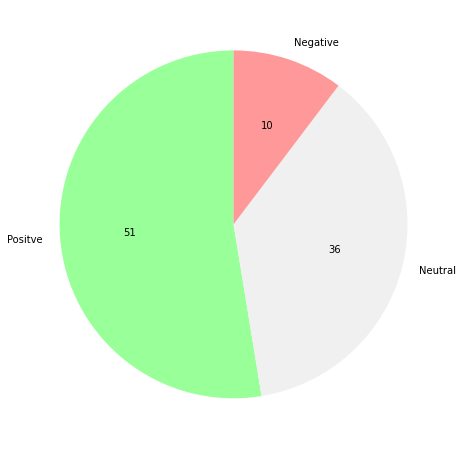

In [382]:
#assign to pie chart. instructions followed from: https://stackoverflow.com/questions/41088236/how-to-have-actual-values-in-matplotlib-pie-chart-displayed#:~:text=If%20you%27re%20looking%20to%20plot%20a%20piechart%20from,autopct%3D%20lambda%20x%3A%20%27%20%7B%3A.0f%7D%27.format%20%28x%2Avalues.sum%20%28%29%2F100%29%2C%20startangle%3D90%29
actual_values = tweets_df['Score'].value_counts(dropna=True)
colors = ['#99ff99','#F0F0F0','#ff9999']
values=tweets_df['Score'].value_counts(dropna=True)
labels = 'Positve','Neutral','Negative' #as defined above

plt.pie(actual_values, colors = colors, labels=labels, autopct= lambda x: '{:.0f}'.format(x*values.sum()/100), startangle=90)

In [383]:
#following this guide: https://www.geeksforgeeks.org/generating-word-cloud-python/

#common used variables 

df = tweets_df['Tweet']
df_values = tweets_df['Score']


comment_words = ''
stopwords = set(STOPWORDS)

text = tweets_df['Tweet'].values 
wordcloud = WordCloud().generate(str(text))


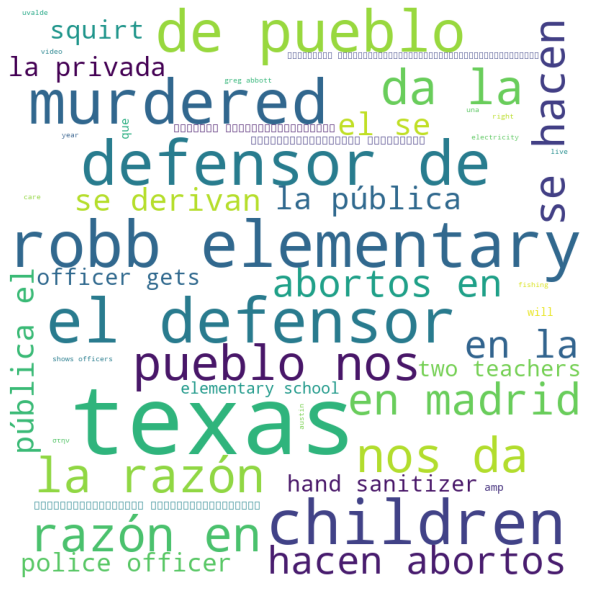

In [384]:
if((tweets_df['Score'] == 'Positive').any()): #assigned word to sentiment value
# iterate through the results
    for val in df:
        
        # typecaste each val to string
        val = str(val)
    
        # split the value
        tokens = val.split()
        
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        
        comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

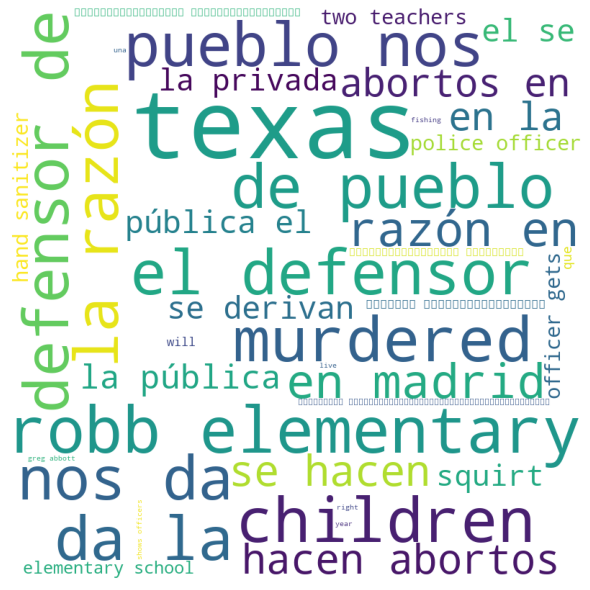

In [385]:
if((tweets_df['Score'] == 'Negative').any()): #assigned word to sentiment value
# iterate through the csv file
    for val in df:
        
        # typecaste each val to string
        val = str(val)
    
        # split the value
        tokens = val.split()
        
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        
        comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

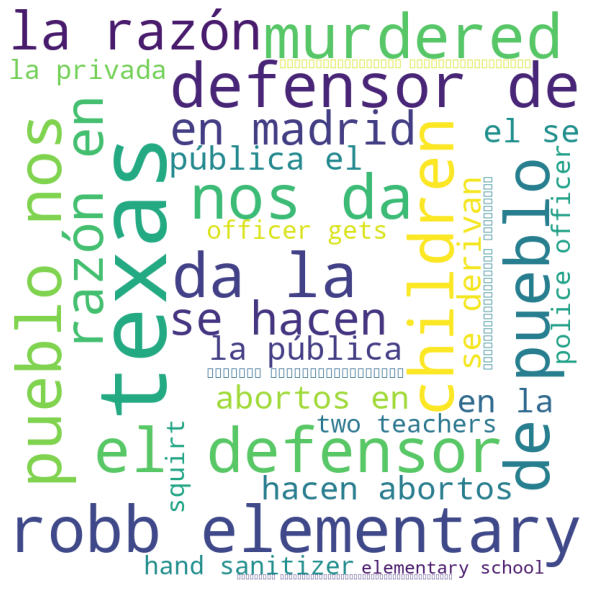

In [386]:
if((tweets_df['Score'] == 'Neutral').any()): #assigned word to sentiment value
# iterate through the csv file
    for val in df:
        
        # typecaste each val to string
        val = str(val)
    
        # split the value
        tokens = val.split()
        
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        
        comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()